<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Sebastian Tinoco
- Auxiliar: Catherine Benavides, Consuelo Rojas
- Ayudante: Eduardo Moya, Nicolás Ojeda

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Fabián Palma
- Nombre de alumno 2: Tomás Guzmán


### **Link de repositorio de GitHub:** `github.com/tomasfabianMDS/LABS`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Colab Notebooks/2024/Lab10"

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv(path + '/diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.). Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes?,
  * ¿Qué buscan explicar las métricas utilizadas?
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?

In [4]:
!pip install xgboost

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Separar características y target
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir las columnas numéricas y categóricas
numeric_features = ['Age', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth']
categorical_features = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                        'DiffWalk', 'Stroke', 'HighBP']

# Crear el preprocesador
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Crear el pipeline con el preprocesador y el modelo XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.7488506966546432
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



El modelo de XGBoost entrenado tiene una accuracy de aproximadamente 0.75 (75%). Esto indica que el modelo es capaz de predecir correctamente si un paciente tiene diabetes en aproximadamente un 75% de los casos. Además, el classification report proporciona más detalles y nos indica que el modelo tiene un rendimiento equilibrado entre ambas clases (pacientes con y sin diabetes).

Más que una explicación de algo, las métricas nos indican cómo se está comportando el modelo en términos de predicción. Esto nos permite hacernos una mejor idea sobre este al momento de evaluarlo. Si la idea es responder con mayor detalle qué representa cada métrica tenemos que:

Accuracy: Proporción de predicciones correctas sobre el total de predicciones. En este caso, el modelo predice correctamente el 75% de las veces.

Precision: Proporción de verdaderos positivos entre las predicciones positivas. Para la clase 0, el 77% de las veces que el modelo predice que un paciente no tiene diabetes, es correcto. Para la clase 1, el 73% de las veces que el modelo predice que un paciente tiene diabetes, es correcto.

Recall: Proporción de verdaderos positivos entre todas las muestras que son realmente positivas. Para la clase 0, el 71% de los pacientes que realmente no tienen diabetes son identificados correctamente. Para la clase 1, el 79% de los pacientes que realmente tienen diabetes son identificados correctamente.

F1-Score: Media armónica de precision y recall. Para la clase 0 es 0.74 y para la clase 1 es 0.76.

Finalmente, y como se mencionó previamente, las métricas de rendimiento (accuracy, precision, recall y F1-score) indican qué tan bien está funcionando el modelo en términos de predicción, pero no proporcionan información directa sobre la importancia o relevancia de las características. Para evaluar si el modelo está haciendo una buena elección de características, puede ser útil utilizar métodos de interpretabilidad como Permutation Feature Importance y SHAP.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`.
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados.
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [6]:
# Obtener los nombres de las columnas después de la transformación
def get_feature_names(preprocessor, numeric_features, categorical_features):
    # Obtener los nombres de las columnas numéricas
    numeric_feature_names = numeric_features

    # Obtener los nombres de las columnas categóricas
    ohe = preprocessor.transformers_[1][1].named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_features)

    # Combinar los nombres de las columnas numéricas y categóricas
    feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

    return feature_names

feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)

<Figure size 1000x800 with 0 Axes>

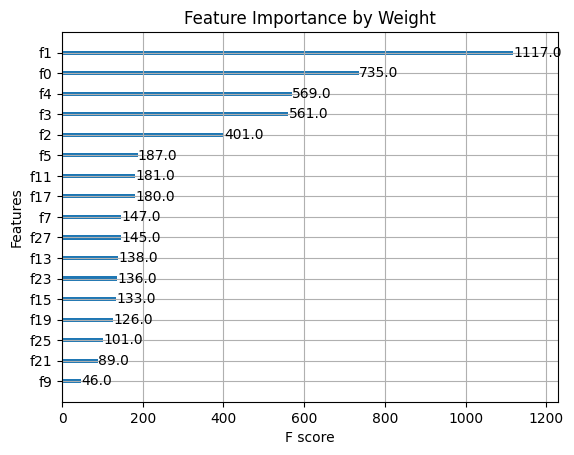

<Figure size 1000x800 with 0 Axes>

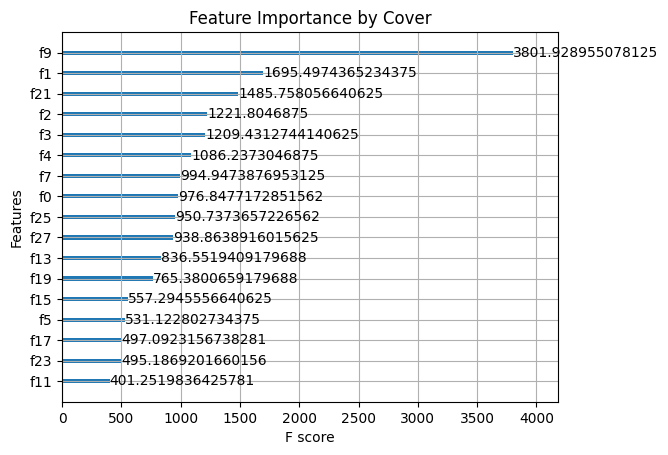

<Figure size 1000x800 with 0 Axes>

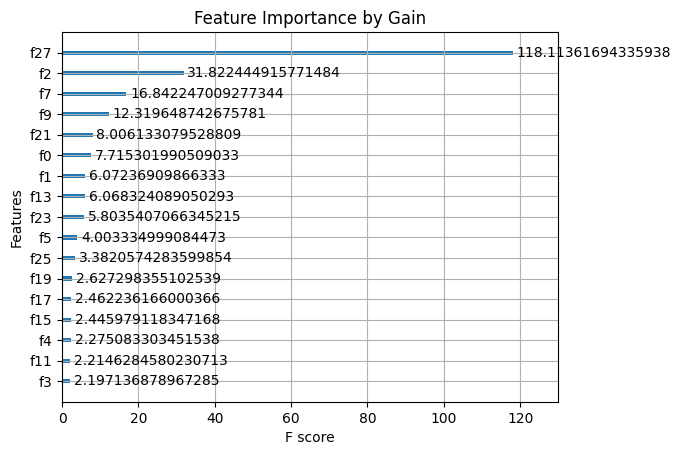

In [7]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Obtener el modelo XGBoost del pipeline
xgb_model = model.named_steps['classifier']

# Visualizar la importancia de las características usando 'weight'
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight')
plt.title('Feature Importance by Weight')
plt.show()

# Visualizar la importancia de las características usando 'cover'
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='cover')
plt.title('Feature Importance by Cover')
plt.show()

# Visualizar la importancia de las características usando 'gain'
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

Los resultados no parecieran ser tan compatibles, salvo algunas excepciones como f1, que es importante tanto en weight como en cover.

Weight representa el número de veces que una característica se usa para dividir el nodo en todos los árboles. Cover representa la proporción de observaciones afectadas por las características a lo largo de los nodos y gain mide la mejora en precisión que proporciona una característica en la rama donde se usa. Podría decirse que es la métrica más informativa ya que mide el impacto de la característica en la precisión del modelo.

En este sentido, no es tan descabellado pensar que las características importantes difieran entre los métodos ya que weight, cover y gain miden diferentes aspectos del modelo. Por ejemplo, weight podría destacar características que se usan frecuentemente pero no necesariamente aportan mucha información. cover muestra características que afectan muchas observaciones, mientras que gain muestra aquellas que más mejoran el modelo.

Si bien gain es la medida más informativa, las importancias de características en árboles no siempre capturan relaciones complejas o interacciones entre características. Además, estas importancias no reflejan cómo las características afectan las predicciones en cada instancia. Algunas debilidades podrían ser, entonces, que la importancia de características no capta bien las interacciones entre características; que si varias características son redundantes, una puede aparecer como muy importante mientras que las otras parecen menos importantes, aunque todas sean igualmente relevantes; y que las importancias pueden estar sesgadas hacia características con más niveles en el caso de datos categóricos.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features.
2. Visualice los resultados de este método en un gráfico.
3. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?).
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta?
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido?
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado.

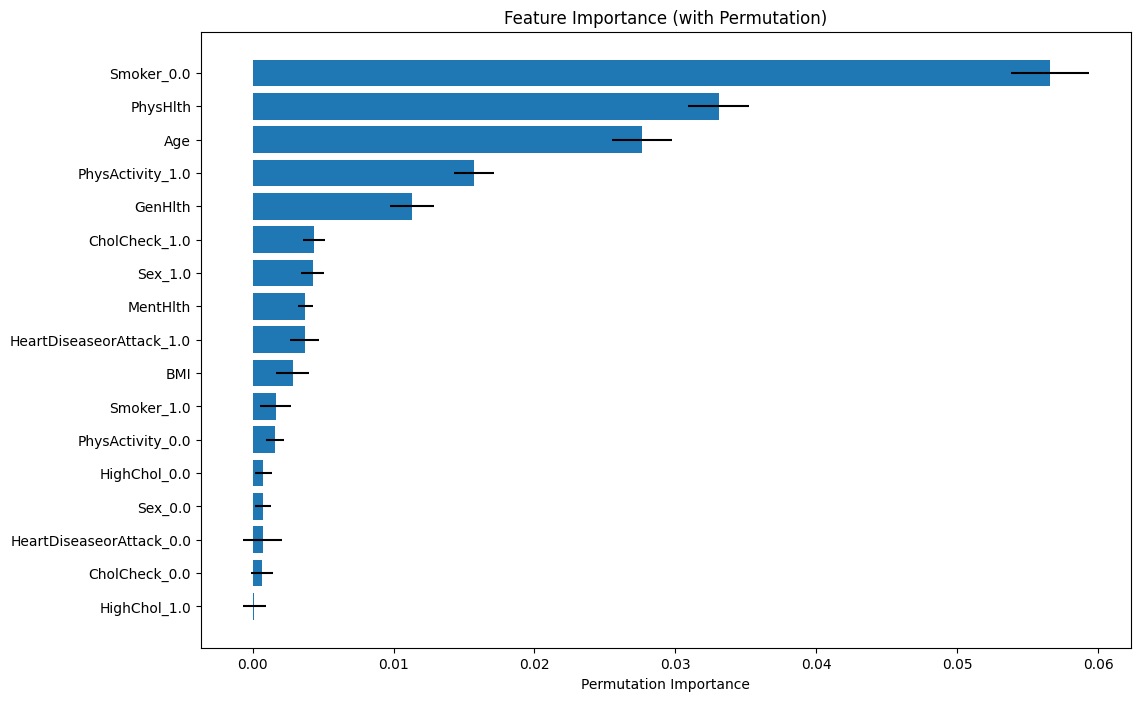

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Repetir el proceso de permutación 30 veces
n_repeats = 30
result = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=42, n_jobs=2)

# Calcular la media y la desviación estándar de las importancias
perm_importances_mean = result.importances_mean
perm_importances_std = result.importances_std

# Ordenar los índices de las importancias
sorted_idx = perm_importances_mean.argsort()

# Visualizar los resultados
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importances_mean[sorted_idx], xerr=perm_importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (with Permutation)")
plt.show()

In [10]:
# Mostrar las 5 características con mayor impacto
top_5_features = sorted_idx[-5:]
for i in reversed(top_5_features):
    print(f"{feature_names[i]}: Mean={perm_importances_mean[i]:.4f}, Std={perm_importances_std[i]:.4f}")

Smoker_0.0: Mean=0.0565, Std=0.0028
PhysHlth: Mean=0.0331, Std=0.0022
Age: Mean=0.0276, Std=0.0021
PhysActivity_1.0: Mean=0.0157, Std=0.0014
GenHlth: Mean=0.0113, Std=0.0016


La desviación estándar de las importancias nos indica la variabilidad de las importancias calculadas en las diferentes permutaciones. Una alta desviación estándar sugiere que la importancia de la característica varía mucho entre las permutaciones, lo que puede indicar inestabilidad en la importancia de esa característica.

La importancia de las características se mide observando la disminución en la precisión del modelo cuando se permuta una característica. Si permutar una característica reduce significativamente la precisión del modelo, esa característica se considera importante.

No somos médicos, pero si tienen sentido. Las 5 primeras features son si la persona es fumadora, su salud física, su edad, si hace actividad física y su salud general. En la literatura y si uno consulta con un médico, en general se considera que estas features son relevantes al estudiar la diabetes.

En relación con la sección anterior, la importancia de permutación puede diferir de la importancia medida por weight, cover y gain debido a que mide directamente el impacto en la precisión del modelo, en vez de cuántas veces o cómo se usa una característica en los árboles.

Algunas ventajas del método implementado son:
Interpretabilidad directa: Mide directamente el impacto en la precisión del modelo, lo que puede ser más intuitivo y directamente relacionado con el rendimiento del modelo.
Independencia del modelo: Es agnóstico al modelo, lo que significa que puede ser aplicado a cualquier modelo predictivo, no solo a los basados en árboles.
Captura interacciones: Puede capturar la importancia de las características incluso si dependen de interacciones complejas con otras características.

Algunas desventajas del método implementado son:

Computacionalmente costoso: Requiere múltiples reevaluaciones del modelo, lo que puede ser computacionalmente costoso, especialmente con modelos grandes o conjuntos de datos grandes.
Sensibilidad a la variabilidad: Puede ser sensible a la variabilidad en las repeticiones, lo que puede resultar en importancias menos estables si el modelo es inestable.
Ruptura de la estructura de datos: La permutación puede romper la estructura intrínseca de los datos, lo que puede llevar a importancias poco realistas.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo.
2. ¿Qué representa cada número en su resultado?
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [9]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.3 MB/s eta 0:00:00


In [11]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [12]:
import shap

# Crear un explicador SHAP para nuestro modelo XGBoost
explainer = shap.Explainer(model.named_steps['classifier'], model.named_steps['preprocessor'].transform(X_train))

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(model.named_steps['preprocessor'].transform(X_test))

# Visualizar los valores SHAP para un paciente específico (por ejemplo, el primer paciente en el conjunto de prueba)
shap.initjs()

# Seleccionar el índice de la instancia a explicar
idx = 0

# Crear una explicación
shap_values_patient = shap_values[idx]
shap_explanation = shap.Explanation(values=shap_values_patient.values,
                                    base_values=shap_values_patient.base_values,
                                    data=model.named_steps['preprocessor'].transform(X_test.iloc[[idx]])[0],
                                    feature_names=feature_names)

# Visualizar la explicación con force_plot
shap.force_plot(shap_explanation.base_values, shap_explanation.values, shap_explanation.data, feature_names=feature_names)

 99%|===================| 14001/14139 [01:26<00:00]       

Cada número en los SHAP values representa la contribución de una característica específica a la predicción del modelo para una instancia individual. Los SHAP values descomponen la predicción de un modelo en las contribuciones de cada característica, es decir, permiten entender cómo cada característica influye en la predicción.

También es posible atribuir un significado a la positividad/negatividad de cada SHAP value, en este sentido, un SHAP value positivo indica que la característica aumenta la probabilidad de la predicción positiva (en este caso, la presencia de diabetes), mientras que un SHAP value negativo indica que la característica disminuye la probabilidad de la predicción positiva (presencia de diabetes).

### 5.2 Aporte local (0.4 puntos)


1. Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?

  - ¿Existe algún patrón común entre las instancias analizadas?

  - ¿Es posible generalizar estas conclusiones a todo el dataset?

 99%|===================| 14014/14139 [01:21<00:00]       

Instance 1


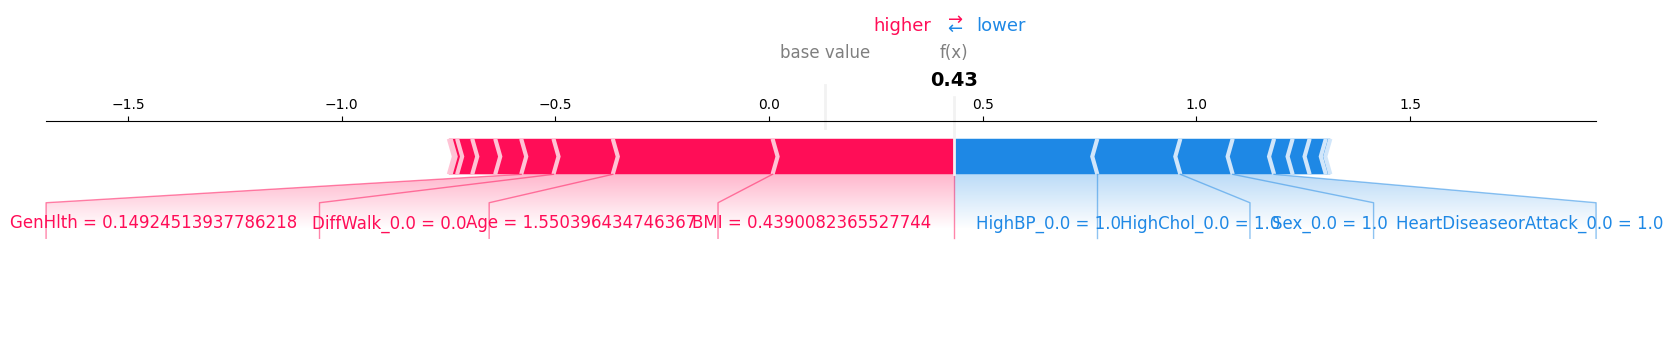

Instance 9


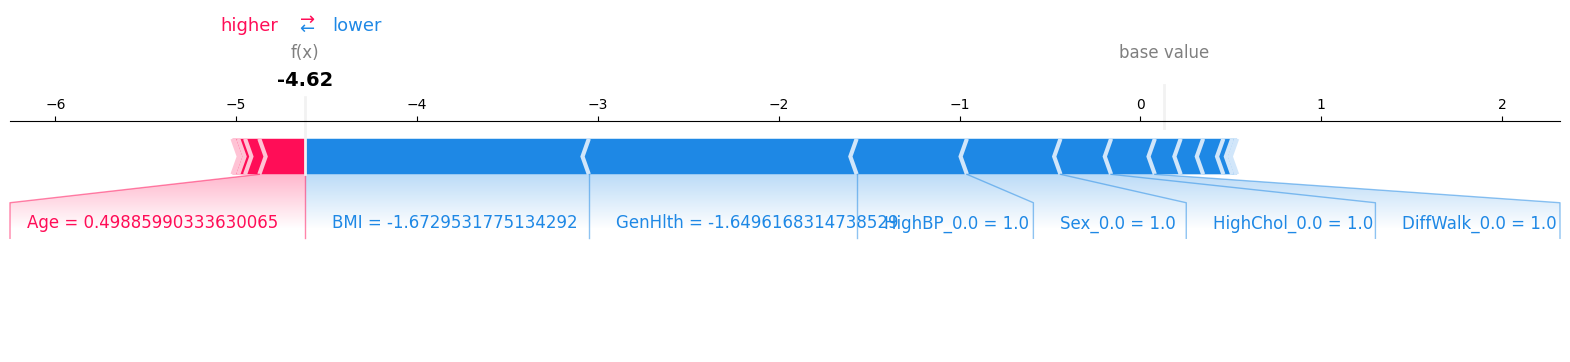

Instance 150


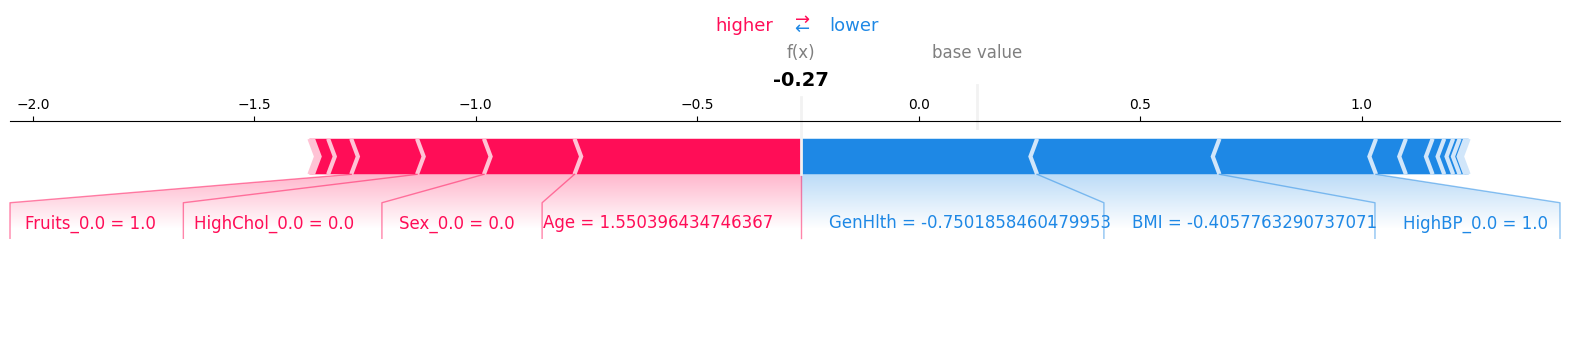

In [13]:
# Crear un explicador SHAP para nuestro modelo XGBoost
explainer = shap.Explainer(model.named_steps['classifier'], model.named_steps['preprocessor'].transform(X_train))

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(model.named_steps['preprocessor'].transform(X_test))

# Instancias específicas a analizar
indices = [1, 9, 150]

# Inicializar JS para SHAP
shap.initjs()

# Visualizar los valores SHAP para las instancias específicas
for idx in indices:
    shap_values_instance = shap_values[idx]
    shap_explanation = shap.Explanation(values=shap_values_instance.values,
                                        base_values=shap_values_instance.base_values,
                                        data=model.named_steps['preprocessor'].transform(X_test.iloc[[idx]])[0],
                                        feature_names=feature_names)
    print(f"Instance {idx}")
    shap.force_plot(shap_explanation.base_values, shap_explanation.values, shap_explanation.data, feature_names=feature_names, matplotlib=True)
    plt.show()

Los valores SHAP positivos aumentan la probabilidad de diabetes, mientras que los valores SHAP negativos disminuyen la probabilidad de diabetes. Podemos ver que en el 1 todos los valores son positivos o indican a que categoría pertenecen. En el 9 son todos positivos excepto BMI y GenHlth. En el 150 ocurre lo mismo que en el anterior, pero tienen distitno sexo y colesterol alto.

En términos de patrones, no afirmaría que hay algo significativo en estos tres casos. Sin embargo pareciera que en Age y GenHlth podrían haber ciertas tendencias.

En relación con lo anterior, no es una buena idea generalizar para el dataset ya que la variabilidad entre instancias individuales puede ser alta. Para generalizar sería mejor usar métodos globales.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

 99%|===================| 13985/14139 [01:20<00:00]       

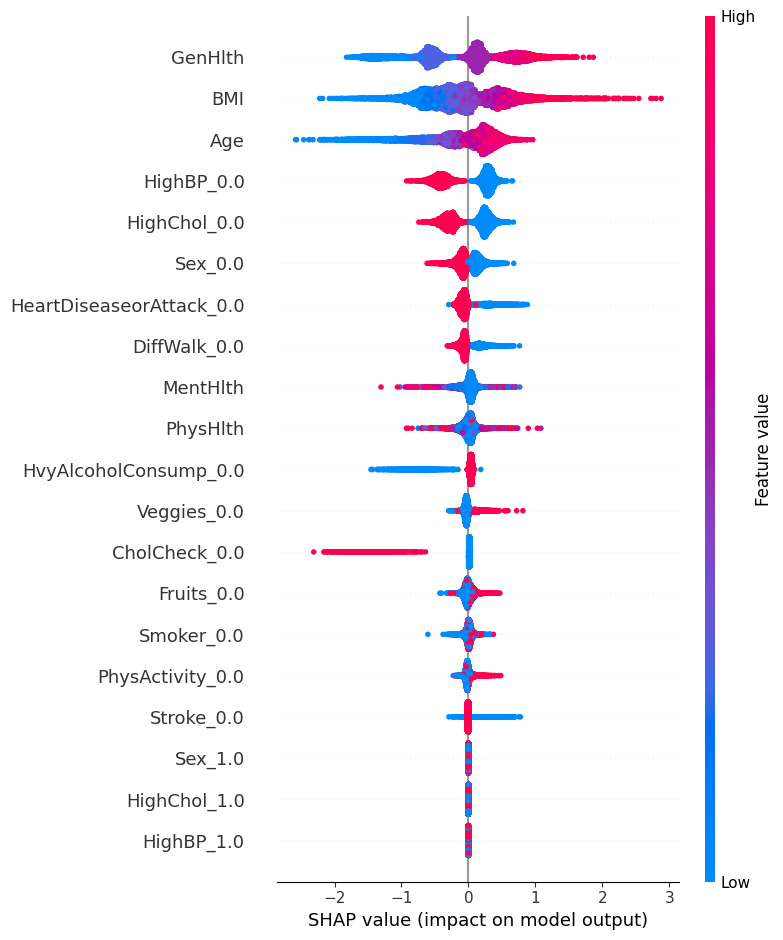

In [14]:
# Crear un explicador SHAP para nuestro modelo XGBoost
explainer = shap.Explainer(model.named_steps['classifier'], model.named_steps['preprocessor'].transform(X_train))

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(model.named_steps['preprocessor'].transform(X_test))

# Generar el gráfico de resumen global
shap.summary_plot(shap_values, model.named_steps['preprocessor'].transform(X_test), feature_names=feature_names)


En este caso tuvimos la suerte de que se condice con las tendencias que destacamos a nivel de instancia en nuestros tres casos. Viendo ahora el BMI, en efecto, también era apreciable en las instancias, sería el que habría que agregar al análisis anterior.

### 5.4 Scatter plot (0.4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

 99%|===================| 13946/14139 [01:17<00:01]       

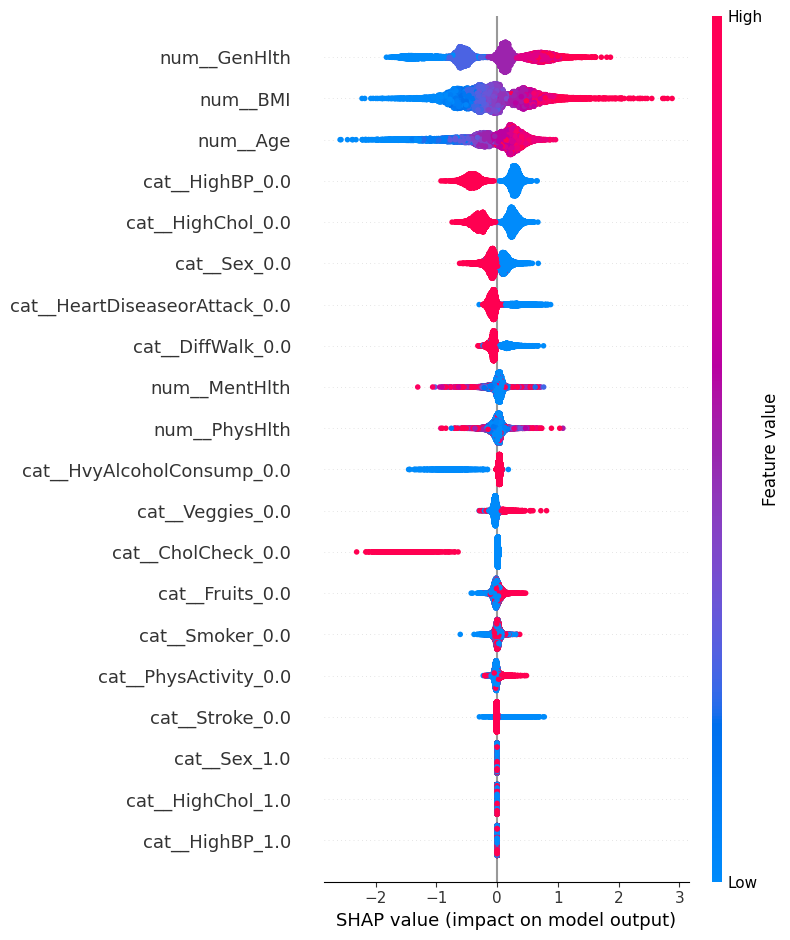

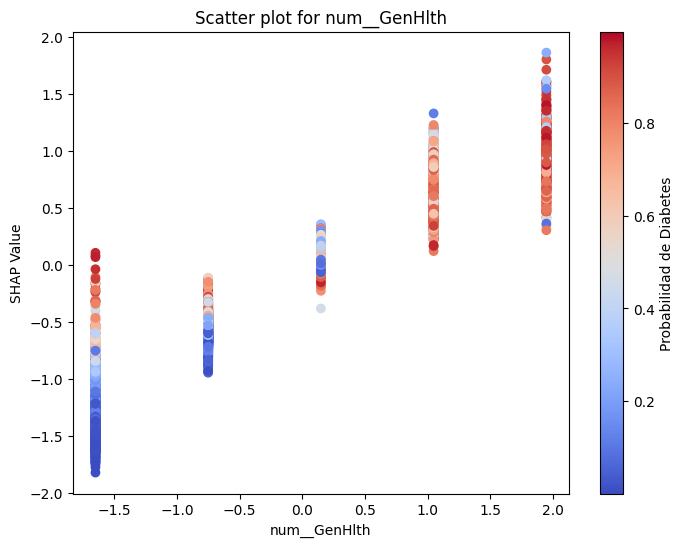

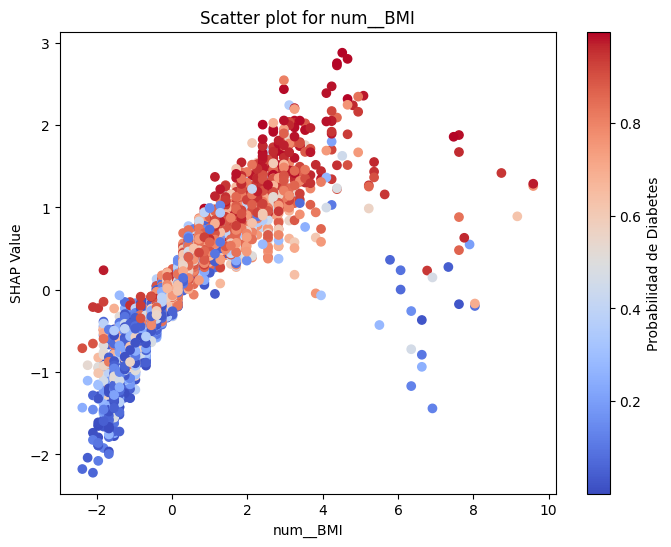

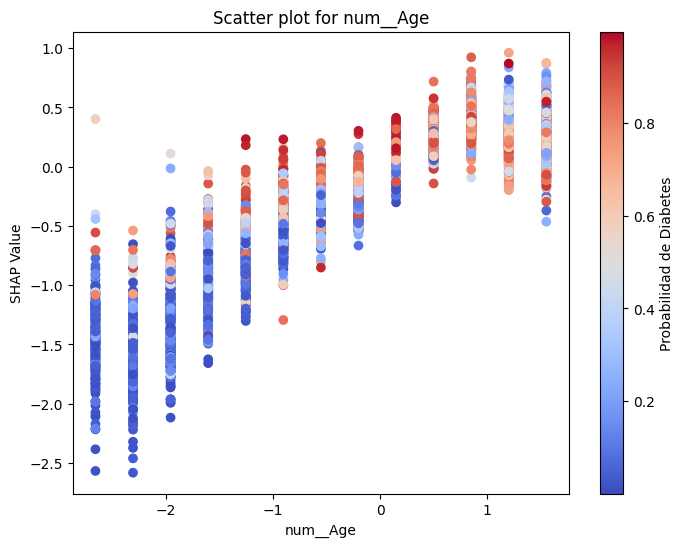

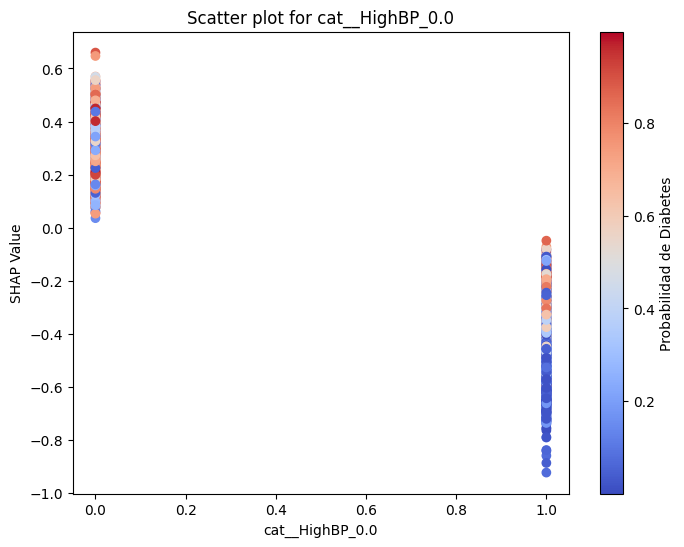

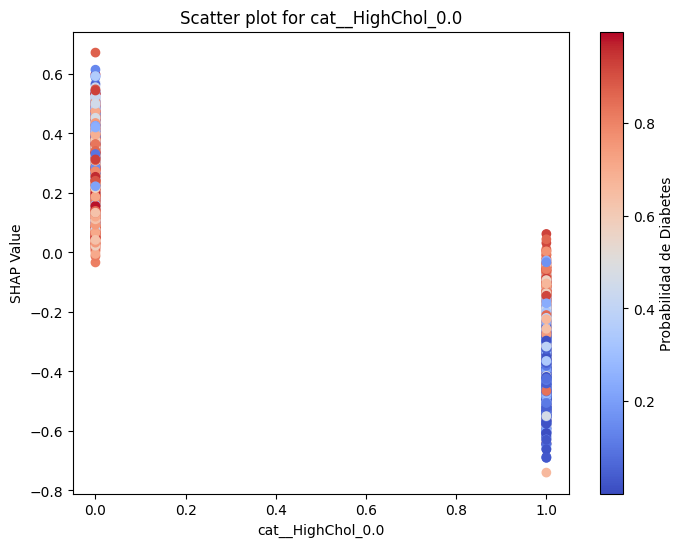

In [15]:
# Crear un explicador SHAP para nuestro modelo XGBoost
explainer = shap.Explainer(model.named_steps['classifier'], model.named_steps['preprocessor'].transform(X_train))

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(model.named_steps['preprocessor'].transform(X_test))

# Calcular las probabilidades de predicción para el conjunto de prueba
probabilities = model.predict_proba(X_test)[:, 1]

# Obtener los nombres de las características después del preprocesamiento
feature_names_transformed = model.named_steps['preprocessor'].get_feature_names_out()

# Generar el gráfico de resumen global para identificar las 5 características más importantes
shap.summary_plot(shap_values, model.named_steps['preprocessor'].transform(X_test), feature_names=feature_names_transformed)

# Convertir feature_names_transformed a lista si no lo es
if isinstance(feature_names_transformed, np.ndarray):
    feature_names_transformed = feature_names_transformed.tolist()

# Extraer los nombres de las 5 características más importantes
importance_order = np.argsort(-np.abs(shap_values.values).mean(0))
top_features = [feature_names_transformed[i] for i in importance_order[:5]]

# Crear scatter plots para las 5 características más importantes
for feature in top_features:
    plt.figure(figsize=(8, 6))
    feature_values = model.named_steps['preprocessor'].transform(X_test)[:, feature_names_transformed.index(feature)]
    shap_feature_values = shap_values.values[:, feature_names_transformed.index(feature)]
    plt.scatter(feature_values, shap_feature_values, c=probabilities, cmap='coolwarm')
    plt.colorbar(label='Probabilidad de Diabetes')
    plt.xlabel(feature)
    plt.ylabel('SHAP Value')
    plt.title(f'Scatter plot for {feature}')
    plt.show()

Si una característica tiene un SHAP value positivo en la mayoría de las instancias donde su valor es alto, podemos concluir que esta característica incrementa la probabilidad de diabetes. Por otra parte, si los colores muestran un gradiente claro (de azul a rojo) en relación con los SHAP values, nos indica una correlación fuerte entre la característica y la probabilidad de diabetes.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para
las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [16]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# Seleccionar las 5 variables con mayor impacto global
top_features = [feature_names_transformed[i] for i in importance_order[:5]]

# Crear una submuestra de 1000 observaciones
sample_indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_sample = X_test.iloc[sample_indices]

# # Generar los gráficos PDP para las 5 variables seleccionadas
# fig, ax = plt.subplots(figsize=(15, 10))
# disp = PartialDependenceDisplay.from_estimator(model.named_steps['classifier'], X_sample, features=top_features, ax=ax, grid_resolution=50)
# plt.suptitle('Partial Dependence Plot para las 5 variables con mayor impacto global', y=1.02)
# plt.tight_layout()
# plt.show()

In [23]:
top_features

['num__GenHlth',
 'num__BMI',
 'num__Age',
 'cat__HighBP_0.0',
 'cat__HighChol_0.0']

In [24]:
preprocessor.transform(X_sample)["num__GenHlth"]


64530    1.048676
65575   -0.750186
14409   -0.750186
36221    0.149245
57023    0.149245
           ...   
56229    1.048676
66581    0.149245
34007   -0.750186
15081   -0.750186
59925    0.149245
Name: num__GenHlth, Length: 1000, dtype: float64

In [20]:
model.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'BMI', 'GenHlth',
                                                   'MentHlth', 'PhysHlth']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'H...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

num__GenHlth


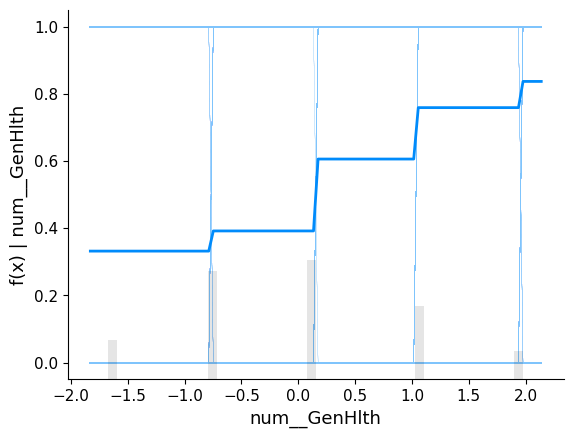

num__BMI


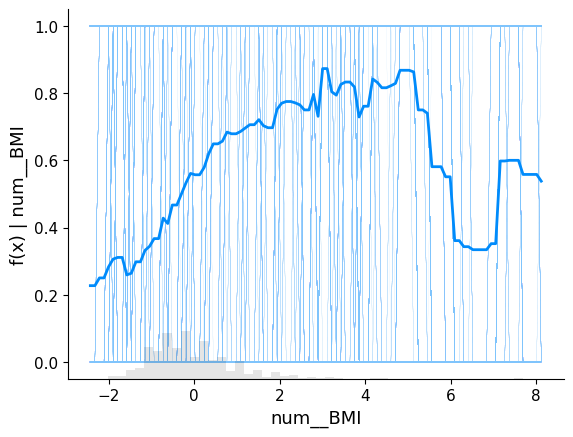

num__Age


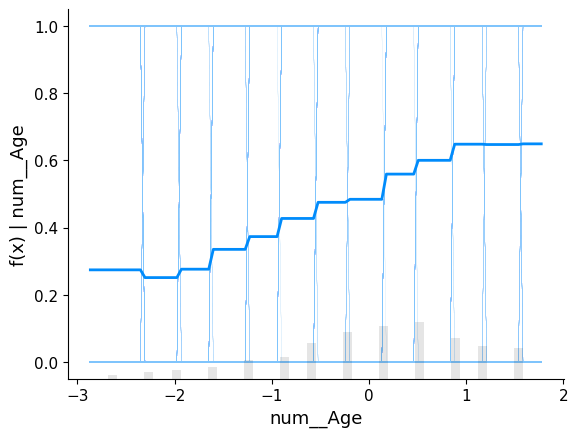

cat__HighBP_0.0


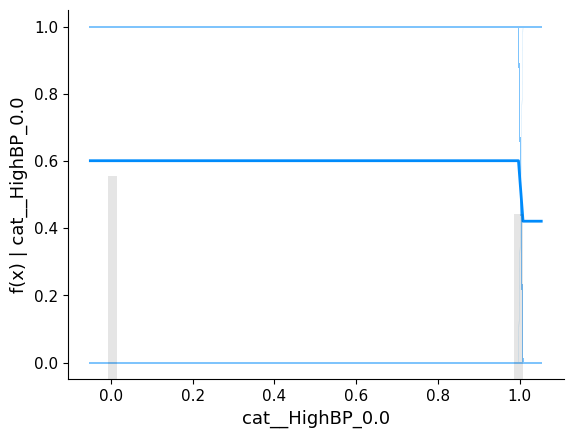

cat__HighChol_0.0


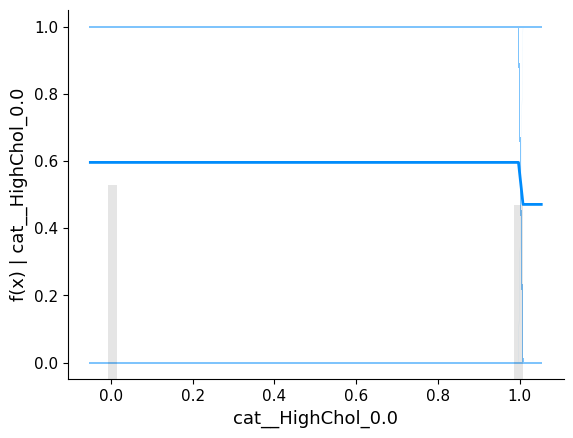

In [25]:
# Calcular SHAP values para las 5 variables con mayor impacto global
top_features = [feature_names_transformed[i] for i in importance_order[:5]]
shap_values = shap.TreeExplainer(model.named_steps['classifier']).shap_values(preprocessor.transform(X_sample))

# Generar los gráficos PDP para las 5 variables seleccionadas
for feature in top_features:
    print(feature)
    shap.partial_dependence_plot(feature, model.named_steps['classifier'].predict, preprocessor.transform(X_sample))

En todos los casos es posible observar relaciones lineales, exceptuando BMI, en que la relación pareciera ser más compleja ya que tiene una forma gaussiana y luego comienza a subir nuevamente al final de la cola.

Los resultados de PDP se basan en una submuestra de 1000 observaciones, por lo que mientras la muestra sea aleatoria y representativa (que es el caso en esta ocasión), si es generalizable. En especial si consideramos que estas características tienen el mayor impacto global en las predicciones del modelo.

## 6. Sistema de Reglas! (1.0 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.1 MB/s eta 0:00:00


In [ ]:
from alibi.explainers import AnchorTabular

In [ ]:
# # Crear el explainer de reglas AnchorTabular
# explainer = AnchorTabular(predictor=model.predict_proba, feature_names=feature_names_transformed)
# explainer.fit(X_train, discretizer='quartile')

# # Seleccionar las observaciones específicas para las cuales explicar las decisiones
# indices_to_explain = [1000, 3001, 5751]
# X_explain = X_test.iloc[indices_to_explain]

# # Explicar las decisiones para las observaciones seleccionadas
# explanations = explainer.explain(X_explain)

# # Obtener las reglas explicativas para cada observación
# for idx, explanation in zip(indices_to_explain, explanations):
#     print(f"Observación {idx}:")
#     print(explanation)
#     print("\n")

# # Calcular la precisión de las reglas en todo el conjunto de datos
# precision = explainer.score(X_test, model.predict(X_test))
# print(f"Precisión de las reglas en todo el conjunto de datos: {precision:.2f}")

# # Calcular el porcentaje de población explicada por las reglas
# population_coverage = explainer.coverage(X_test)
# print(f"Población explicada por las reglas: {population_coverage:.2f}")

In [ ]:
import numpy as np
from alibi.explainers import AnchorTabular
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Obtener el preprocesador y el modelo del pipeline
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']

# Transformar los datos de entrenamiento y prueba
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Crear el explainer de reglas AnchorTabular
explainer = AnchorTabular(predictor=classifier.predict_proba, feature_names=feature_names_transformed)
explainer.fit(X_train_transformed, discretizer='quartile')

# Seleccionar las observaciones específicas para las cuales explicar las decisiones
indices_to_explain = [1000, 3001, 5751]
X_explain_transformed = X_test_transformed[indices_to_explain]

# Explicar las decisiones para las observaciones seleccionadas
explanations = [explainer.explain(X_explain_transformed[i].reshape(1, -1)) for i in range(len(X_explain_transformed))]

# Obtener las reglas explicativas para cada observación
for idx, explanation in zip(indices_to_explain, explanations):
    print(f"Observación {idx}:")
    print(f"Precision: {explanation.precision}")
    print(f"Coverage: {explanation.coverage}")
    print(f"Anchor: {explanation.anchor}")
    print("\n")

# Calcular la precisión de las reglas en todo el conjunto de datos
precision_scores = [explanation.precision for explanation in explanations]
average_precision = np.mean(precision_scores)
print(f"Precisión promedio de las reglas: {average_precision:.2f}")

# Calcular el porcentaje de población explicada por las reglas
coverage_scores = [explanation.coverage for explanation in explanations]
average_coverage = np.mean(coverage_scores)
print(f"Población explicada por las reglas (cobertura promedio): {average_coverage:.2f}")


Observación 1000:
Precision: 0.9722543352601156
Coverage: 0.0742
Anchor: ['num__Age > 0.15', 'cat__HeartDiseaseorAttack_1.0 > 0.00', 'num__BMI > -0.69']


Observación 3001:
Precision: 0.9503030303030303
Coverage: 0.1458
Anchor: ['num__GenHlth > -0.75', 'cat__HighBP_0.0 <= 0.00', 'num__BMI > 0.44']


Observación 5751:
Precision: 0.9922480620155039
Coverage: 0.1117
Anchor: ['num__GenHlth <= -0.75', 'cat__HighBP_0.0 > 0.00', 'num__BMI <= -0.69']


Precisión promedio de las reglas: 0.97
Población explicada por las reglas (cobertura promedio): 0.11


Las reglas propuestas tienen una alta precisión, lo que significa que las predicciones basadas en estas reglas son muy confiables para estas observaciones específicas.
Sin embargo, la cobertura promedio es relativamente baja, lo que indica que estas reglas solo pueden explicar una parte limitada de la población total.
Las reglas propuestas son específicas para las características observadas en estas tres observaciones, pero puede que no sean generalizables para todo el conjunto de datos. Por lo tanto, aunque estas reglas son útiles para explicar las predicciones para estas observaciones particulares, es posible que se necesiten más reglas o características para cubrir la totalidad del conjunto de datos de manera más precisa.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Los métodos implementados en este laboratorio para la tarea de clasificación de diabetes fueron:

1. **XGBoost:** Para entrenar el modelo de clasificación. Tiene una gran capacidad para capturar relaciones complejas entre variables y alto rendimiento en conjuntos de datos de distinta índole.

2. **Métodos Agnósticos Globales de Interpretabilidad (GAI):**
   - **Partial Dependence Plot (PDP):** Proporciona una visión general de cómo una variable afecta la salida promedio del modelo, manteniendo las demás variables constantes. Es útil para entender las relaciones entre características y predicciones a nivel global.
   - **Feature Importance:** Ayuda a identificar las características más influyentes en las predicciones del modelo.

3. **Métodos Agnósticos Locales de Interpretabilidad (LAI):**
   - **SHAP:** Proporciona una explicación local para las predicciones del modelo, mostrando cómo cada característica contribuye a la predicción para una instancia específica. Permite una comprensión detallada de las decisiones del modelo a nivel individual.
   - **Scatter plots y Partial Dependence Plot (PDP) a nivel de instancia:** Ayudan a entender cómo las características afectan las predicciones para casos individuales, permitiendo una interpretación más precisa y detallada.

Para la tarea de clasificación de diabetes, podemos emplear un enfoque mixto ya que los métodos más útiles parecen ser aquellos que combinan tanto la perspectiva global como la local.
- Los métodos globales, como PDP y Feature Importance, proporcionan una comprensión general de cómo las características influyen en las predicciones a nivel global, lo que nos es útil para identificar patrones generales y características importantes.
- Los métodos locales, como SHAP y PDP a nivel de instancia, permiten una interpretación detallada de las predicciones del modelo para casos individuales.

Finalmente, considerando el problema de nuestro querido Dr. Simi, que busca explicar las predicciones del modelo a sus clientes, los métodos agnósticos locales de interpretabilidad parecieran ser más útiles. Esto se debe a que estos métodos proporcionan explicaciones detalladas y comprensibles a nivel individual, lo que permite a nuestro doctor favorito, el Dr. Simi, y su equipo comunicar de manera efectiva las razones detrás de las decisiones del modelo a sus clientes. Esto puede ayudar a generar confianza en el modelo y mejorar la aceptación de las predicciones por parte de los usuarios finales.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>